In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def extract_arch(model):
    vit, size, patch_size, *rest = model.split("-")
    return vit+"-"+size+"-"+patch_size
plt.rcParams['figure.dpi'] = 200

In [2]:
dataset_type = pd.read_csv("dataset_type.csv").set_index("dataset")["type"].to_dict()
df = pd.read_csv("benchmark.csv")
vtab_plus = list(map(lambda s:s.strip(), open("datasets.txt").readlines()))
df = df[df.dataset.isin(vtab_plus)]
df.loc[:, "dataset_type"] = df.dataset.apply(lambda d:dataset_type[d])
df.loc[:, "model_arch"] = df.model.apply(extract_arch)

In [3]:
df_retrieval = df[df["dataset_type"] == "retrieval"]
df = df[df["dataset_type"] != "retrieval"]
df = df.drop(["image_retrieval_recall@5", "text_retrieval_recall@5"], axis=1)
dataset_type = {k:v for k,v in dataset_type.items() if v != "retrieval"}

# Accuracy of all models on all datasets

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

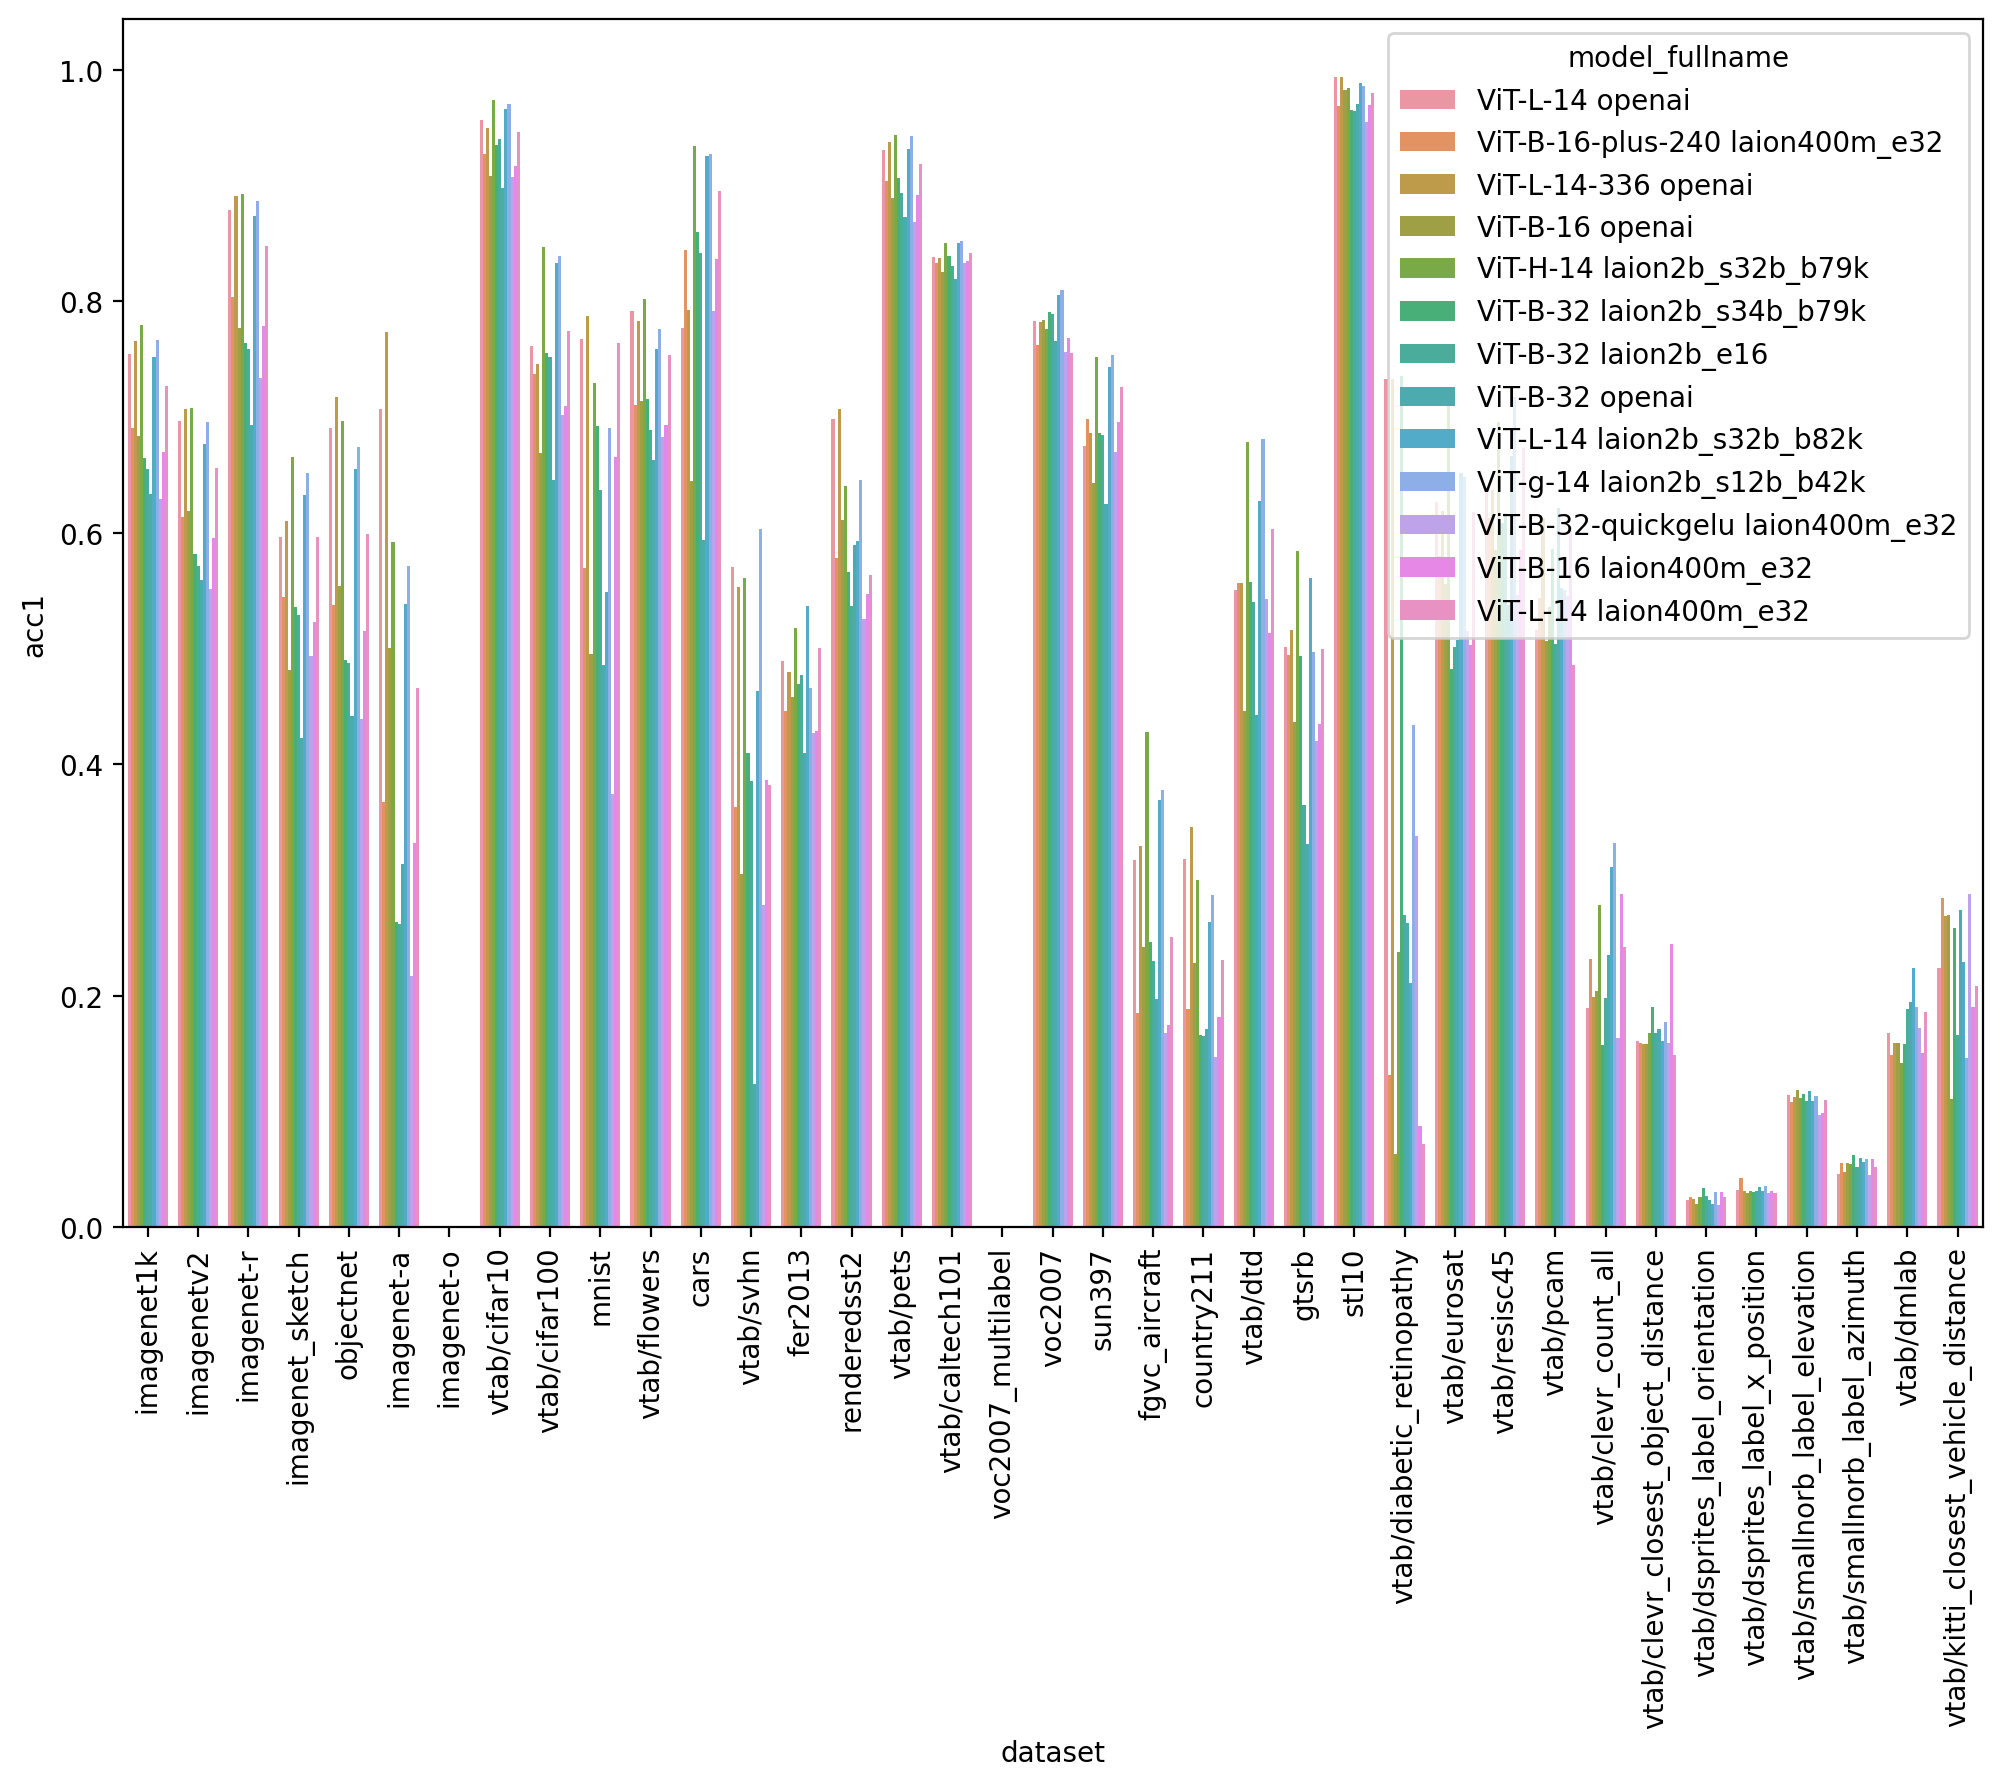

In [12]:
fig = plt.figure(figsize=(12,8))
#order = df.sort_values(by="dataset_type").dataset.unique()
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Zooming on a specific architecture

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

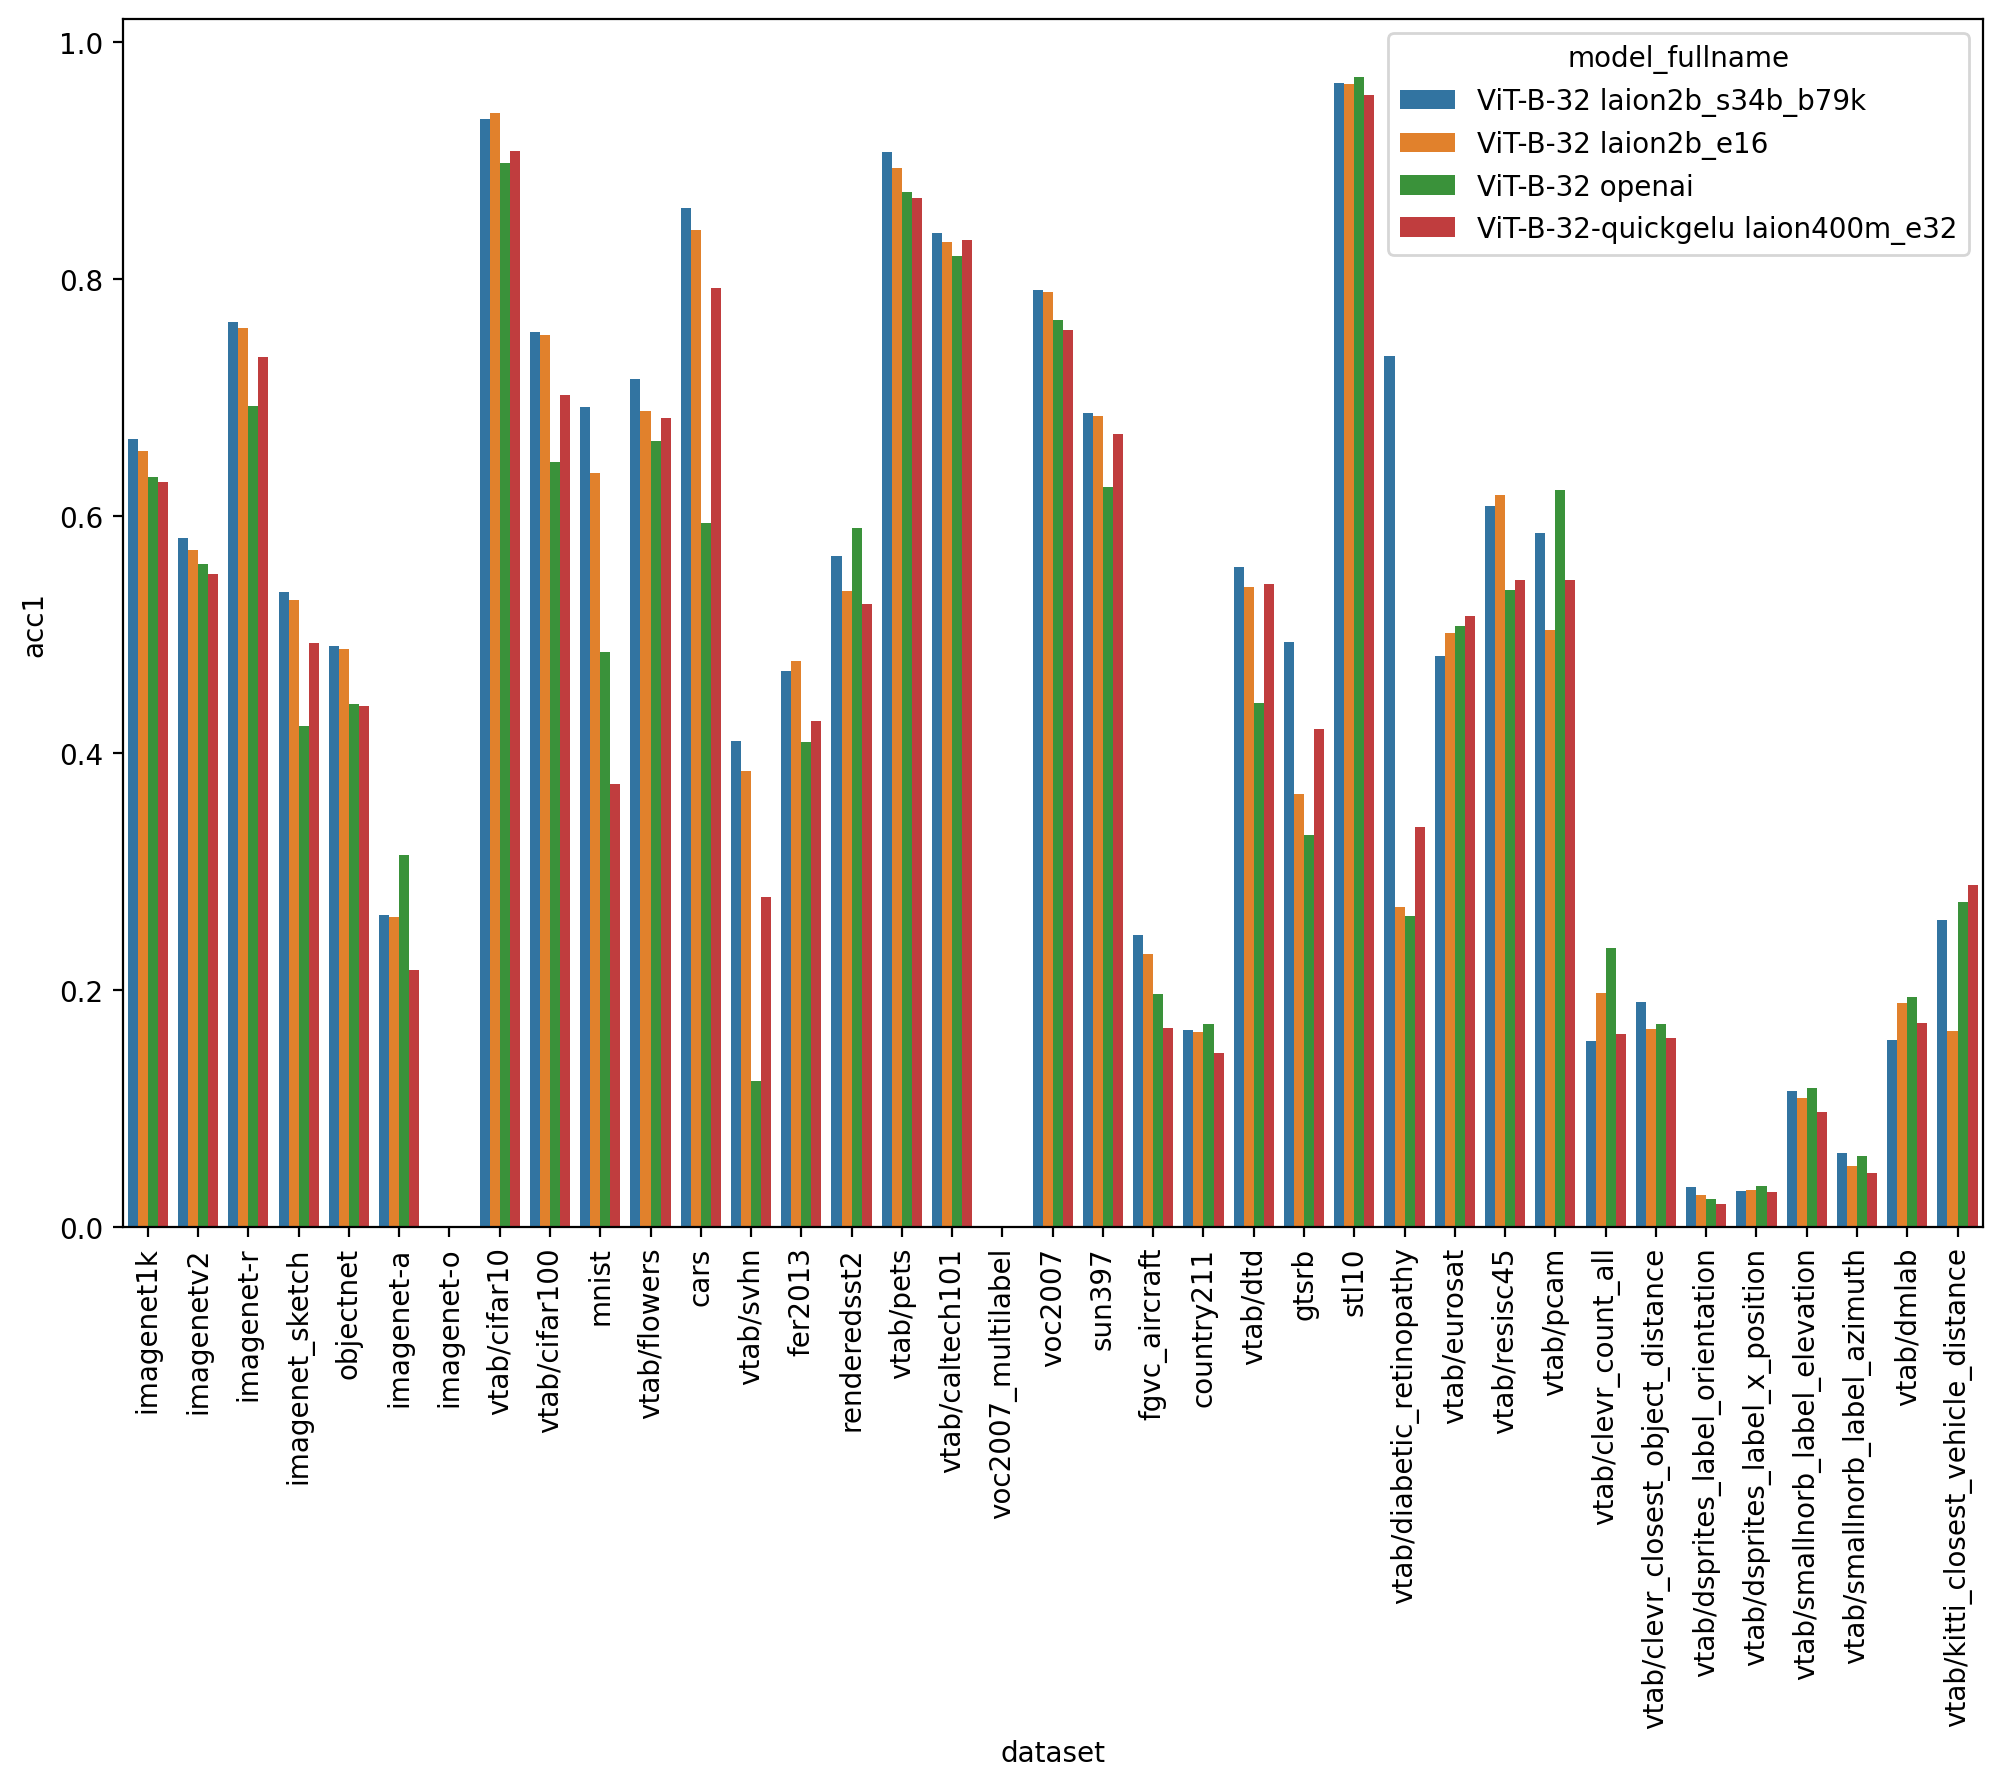

In [13]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df[df.model_arch=="ViT-B-32"]
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Accuracy averaged over all models for each dataset

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

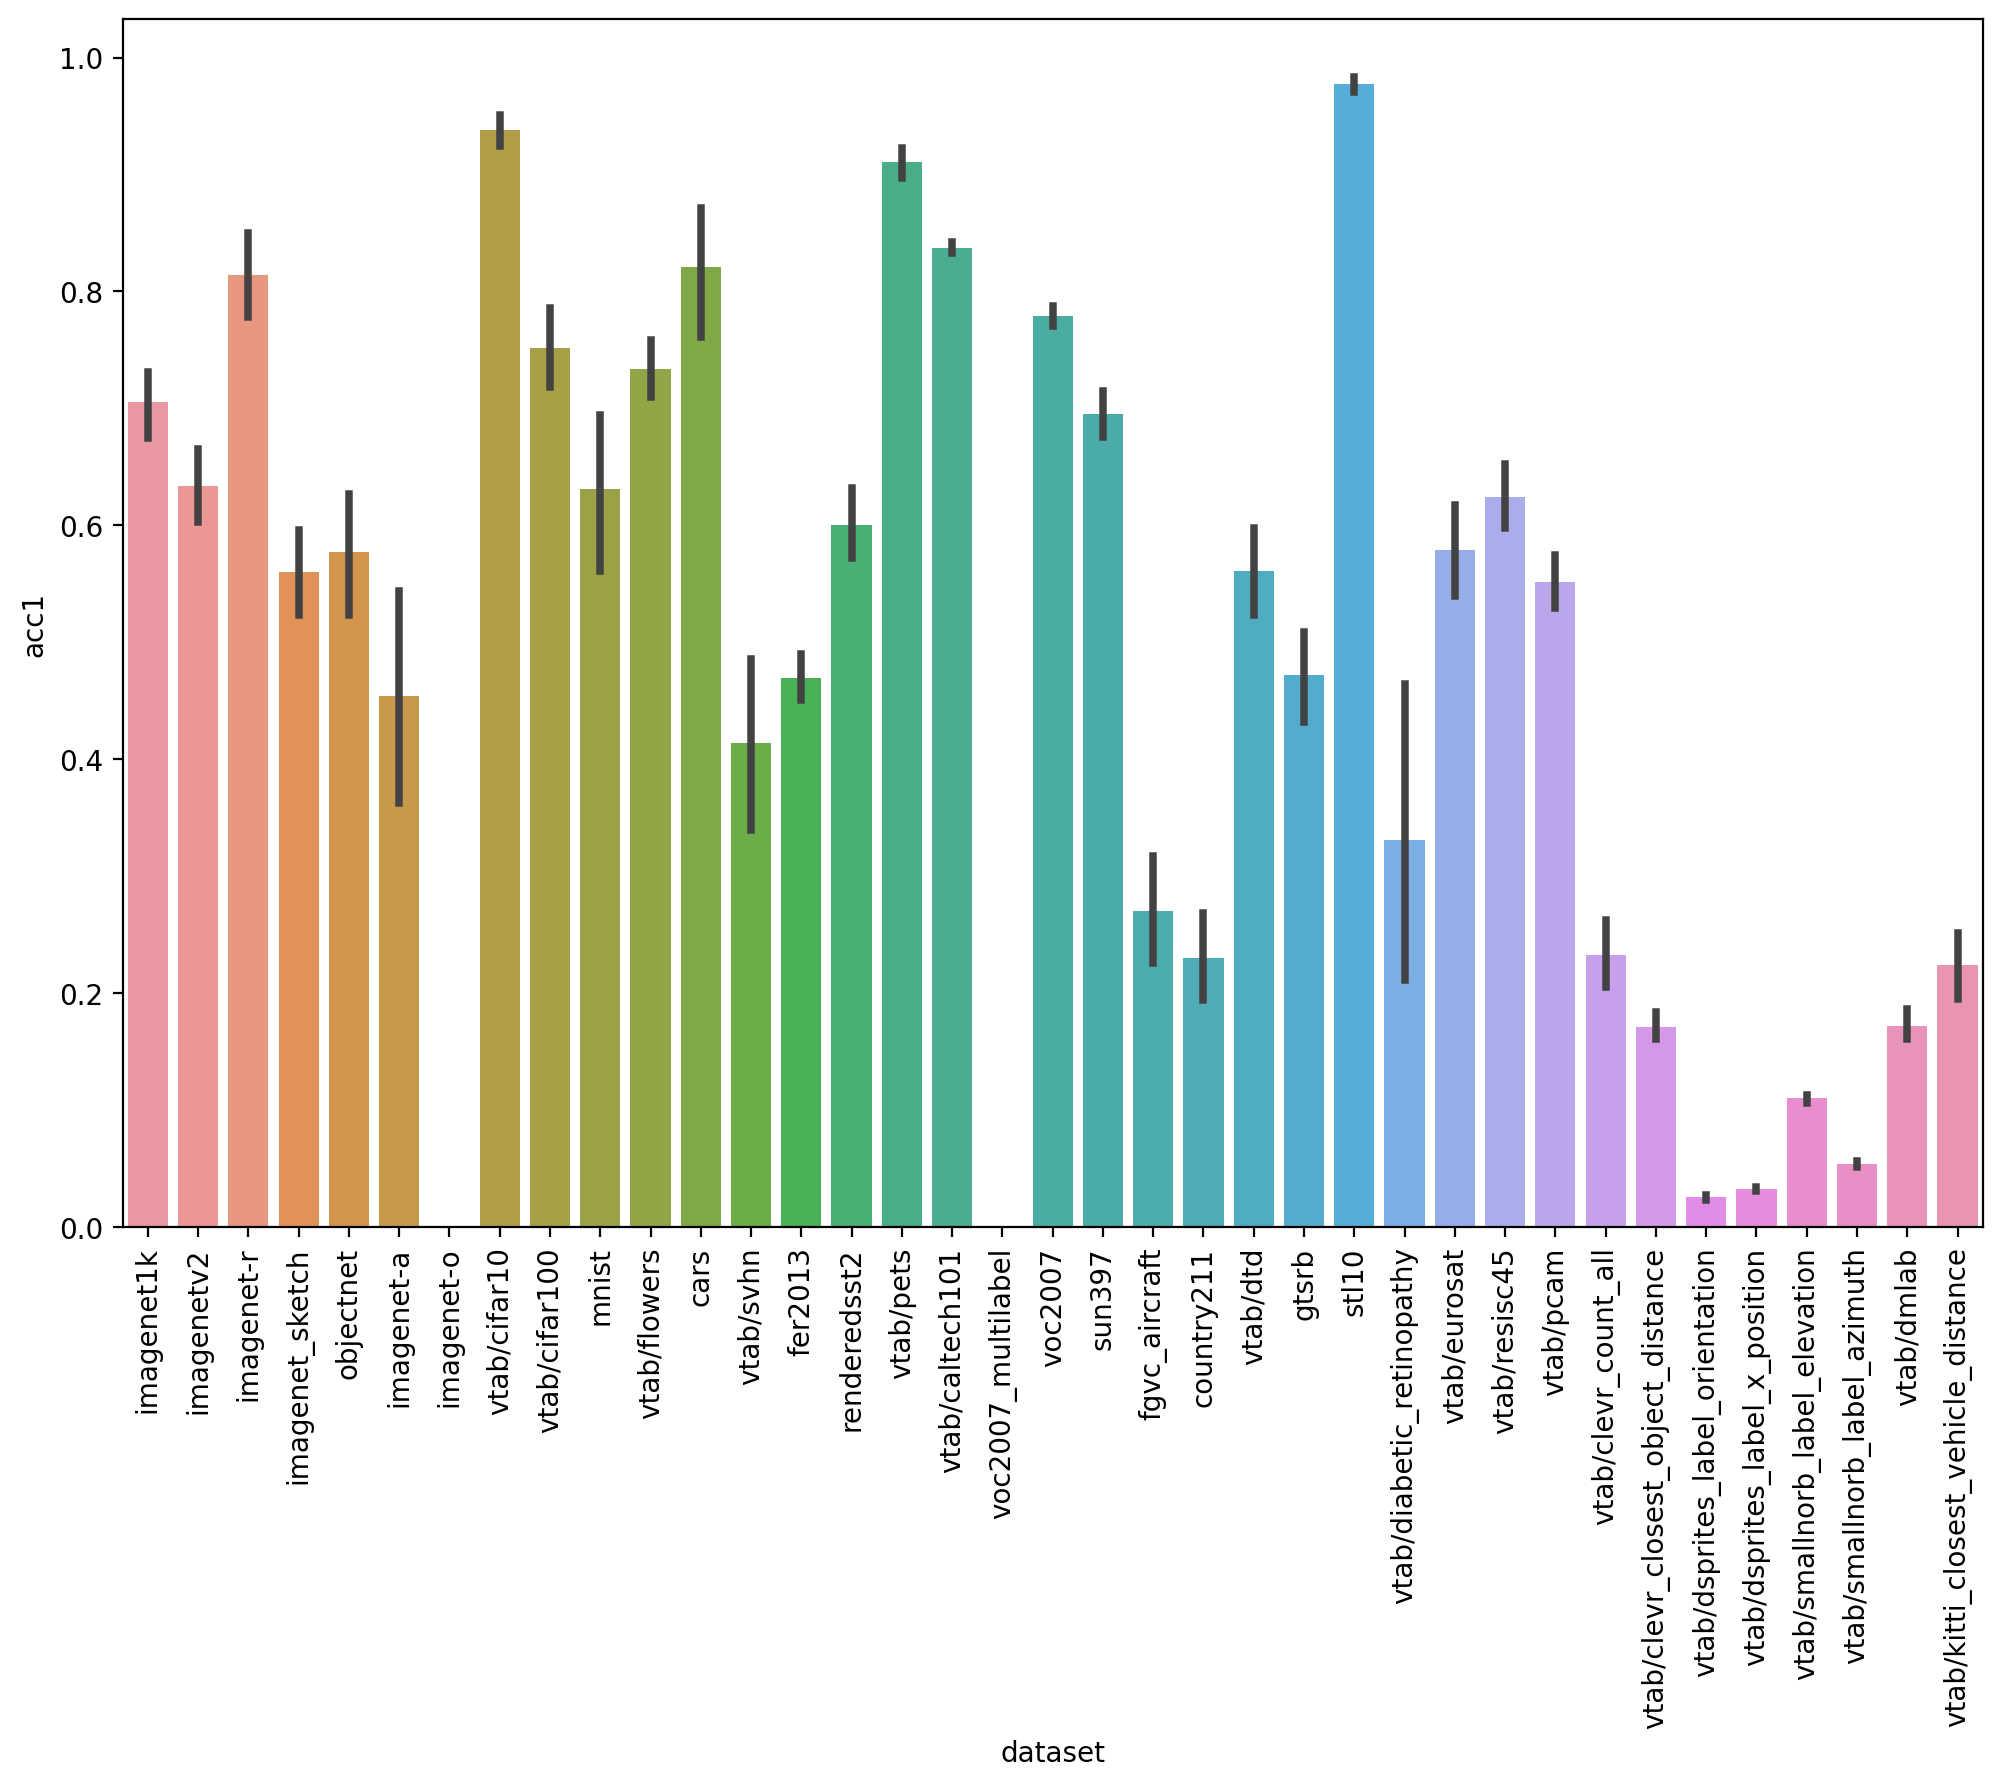

In [14]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", data=df,
    order=order
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over architecture for each dataset

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

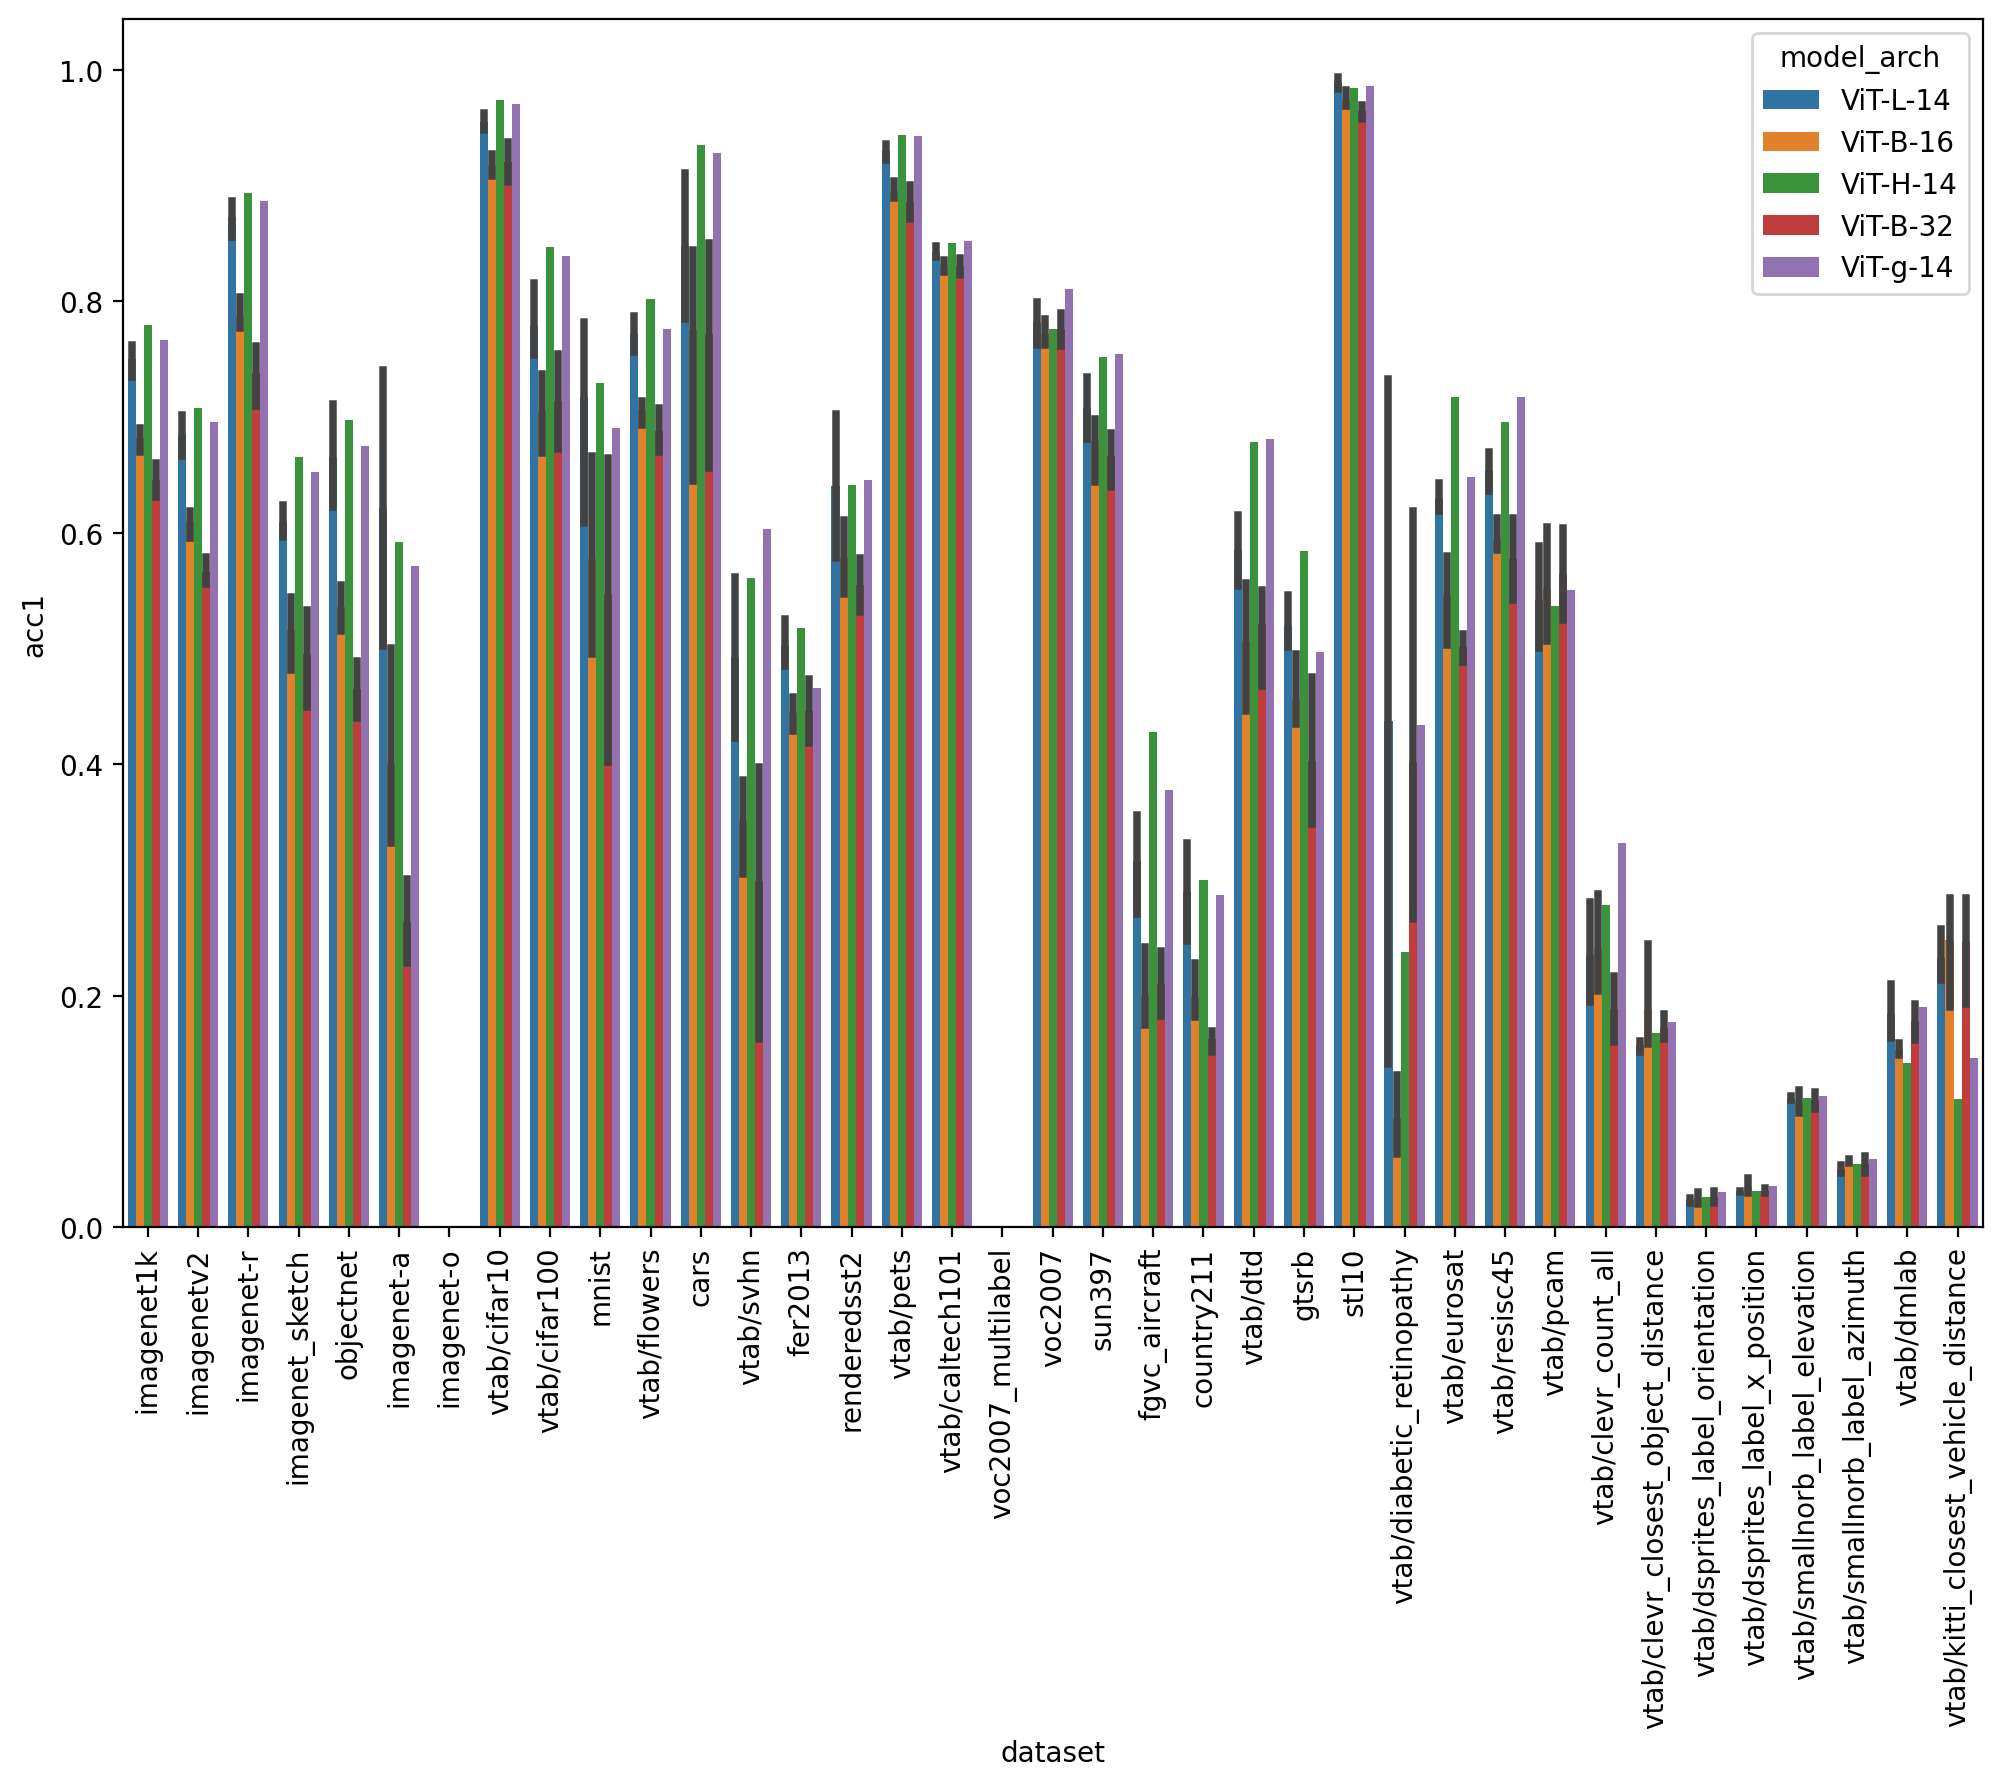

In [15]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_arch"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over pre-training data source

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

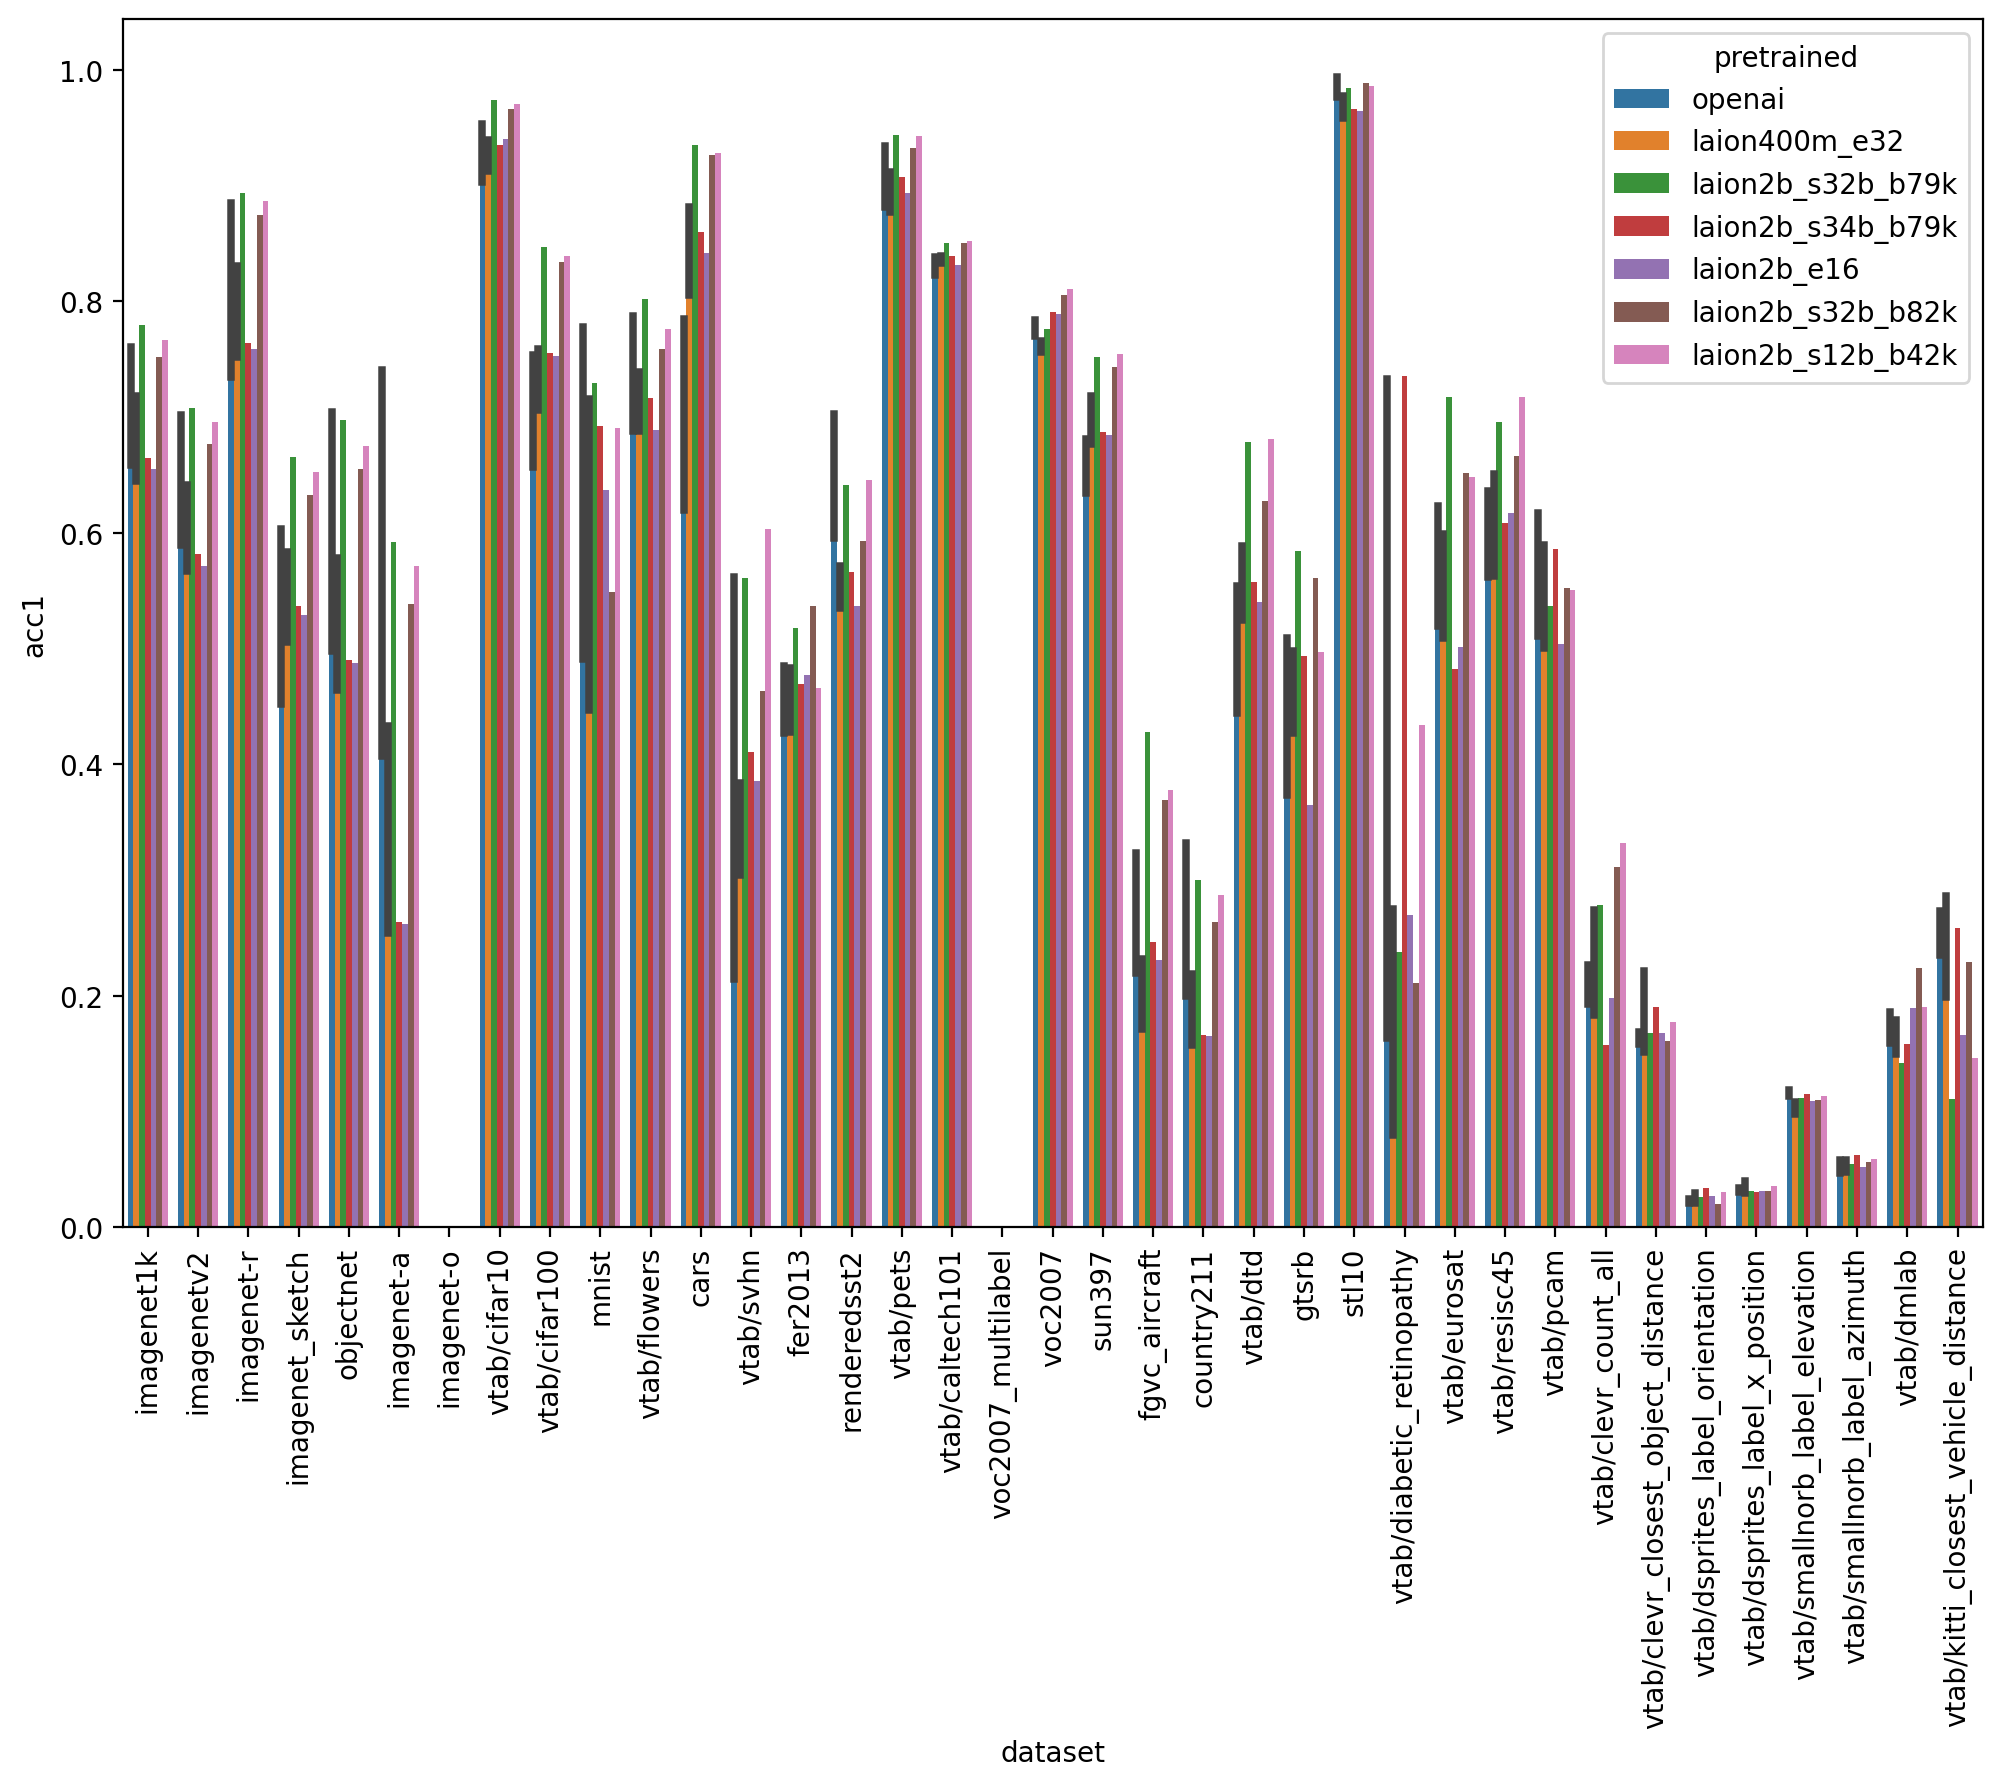

In [18]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Best results from each pre-training source

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

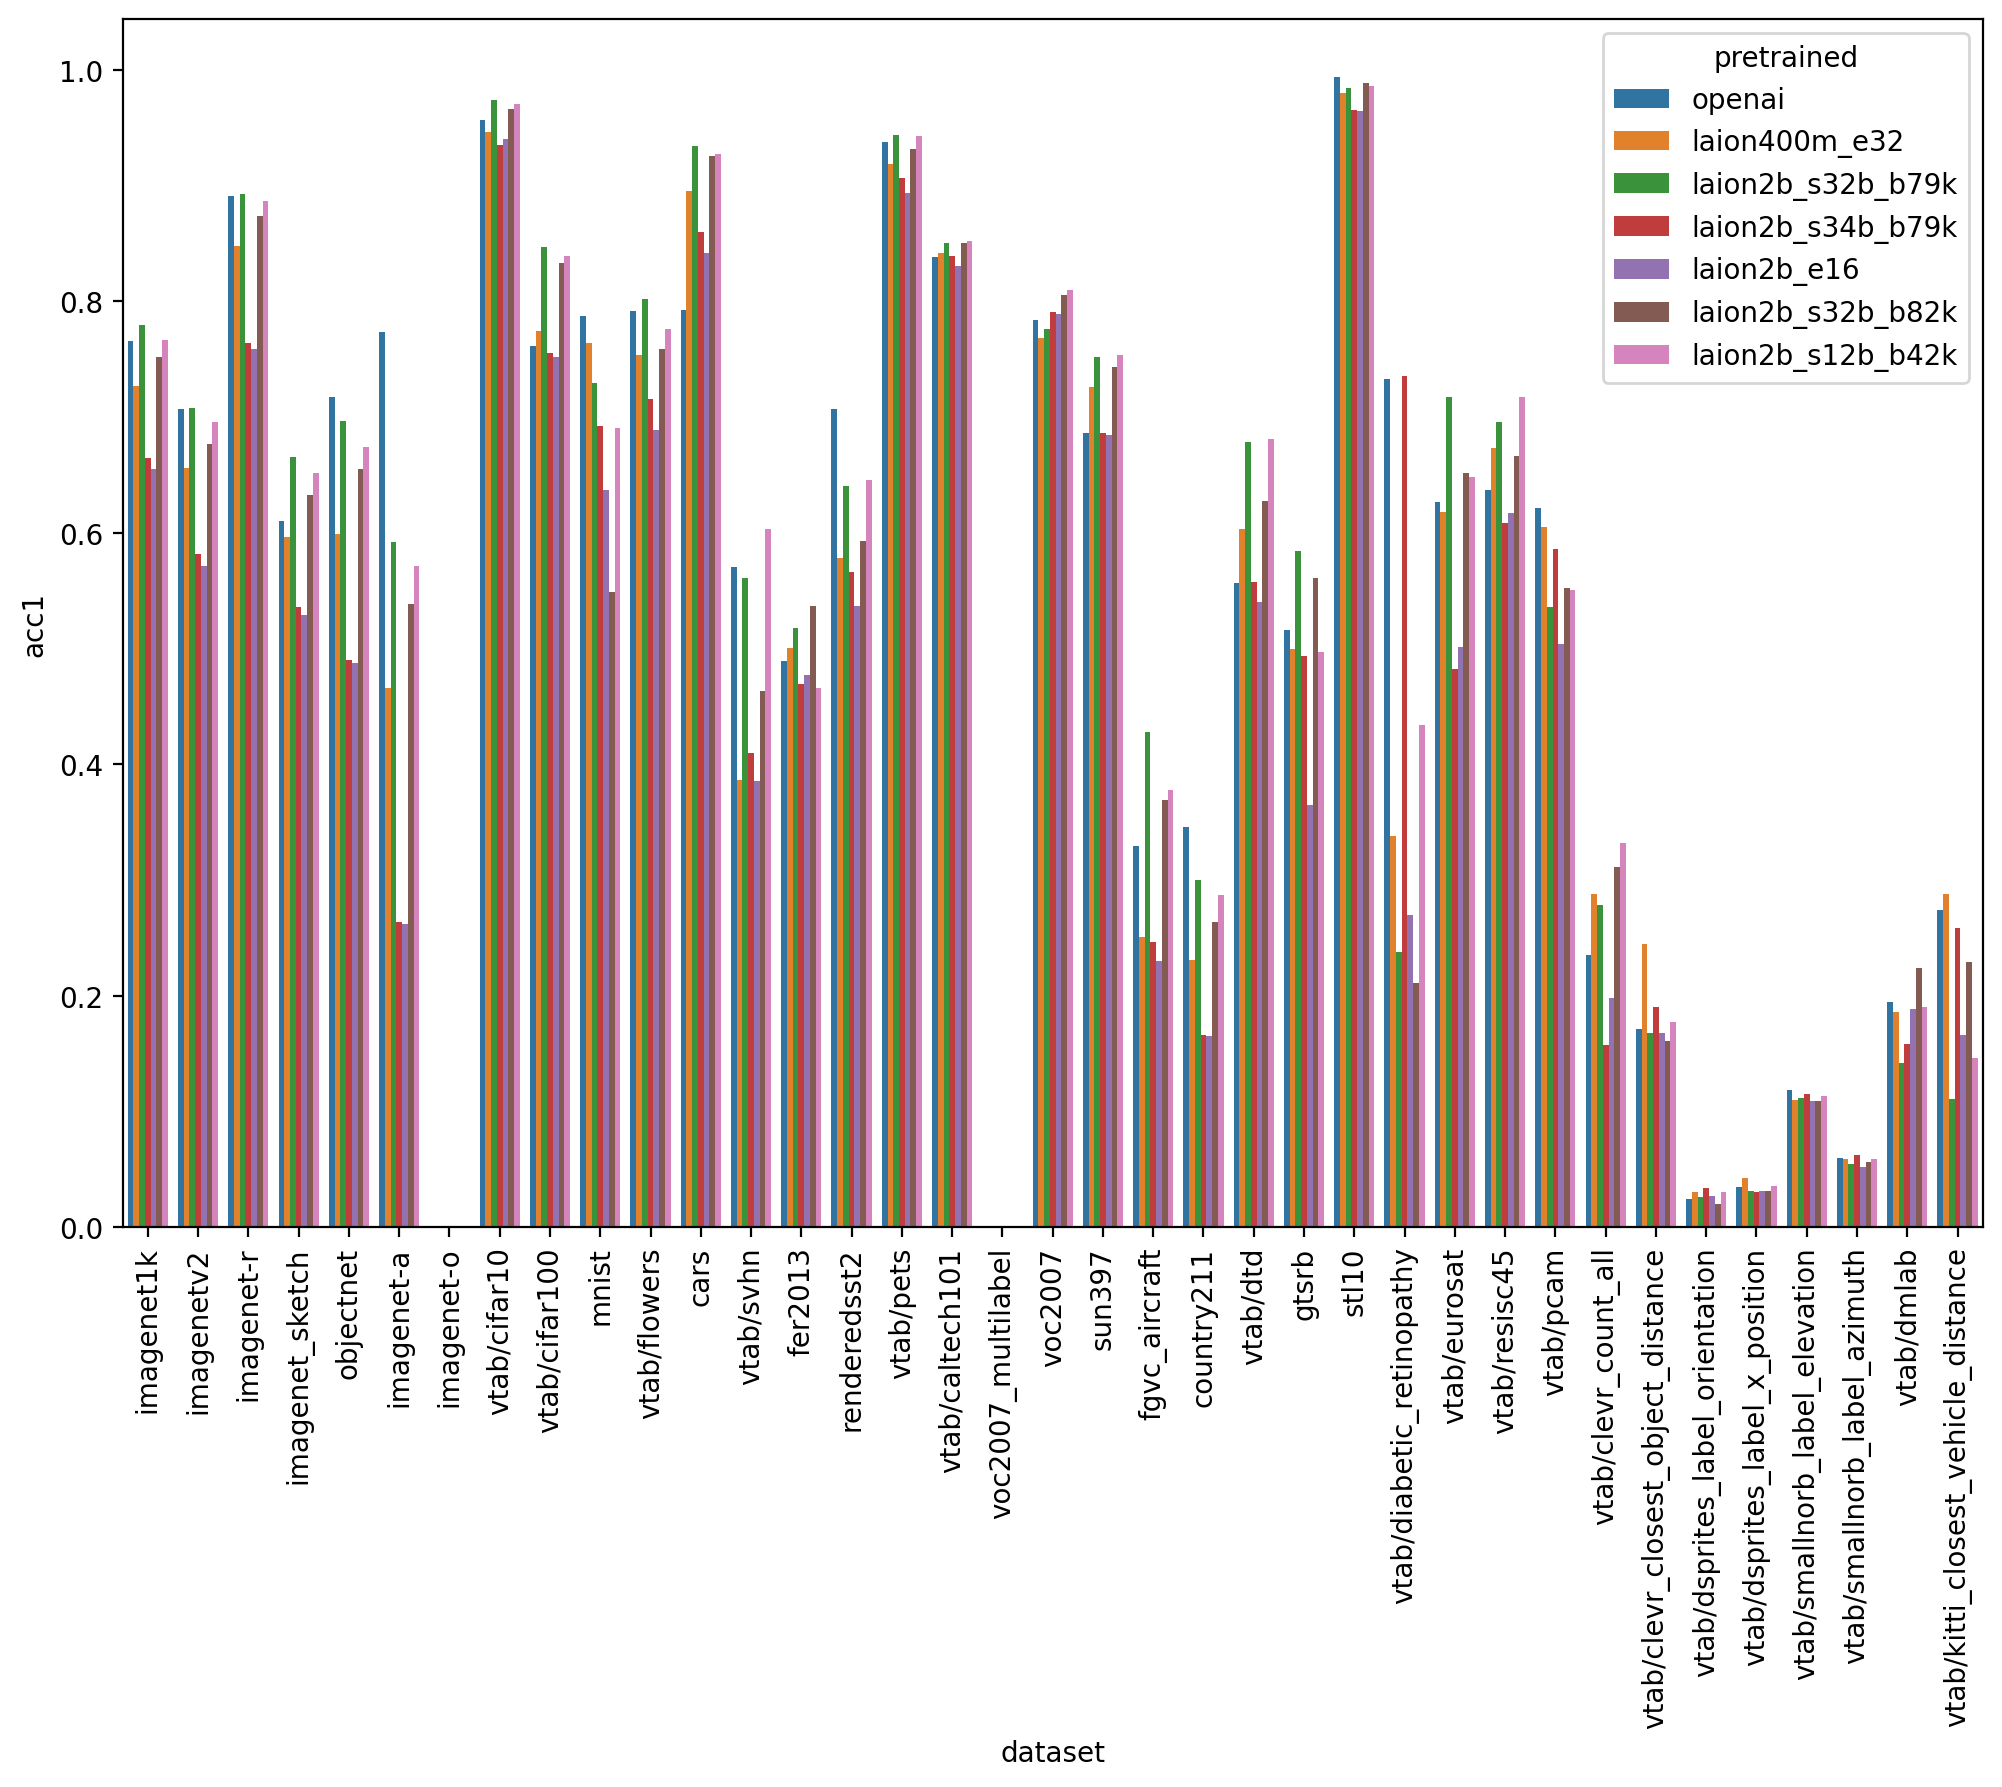

In [20]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained",
    estimator=np.max,
    ci=None
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Detailed results

### All results (acc1)

In [21]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 laion2b_s34b_b79k,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-H-14 laion2b_s32b_b79k,ViT-L-14 laion2b_s32b_b82k,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai,ViT-g-14 laion2b_s12b_b42k
dataset,,,,,,,,,,,,,
cars,0.837,0.645,0.844,0.842,0.860,0.594,0.792,0.935,0.926,0.896,0.777,0.793,0.928
country211,0.181,0.228,0.188,0.165,0.166,0.172,0.147,0.300,0.264,0.231,0.318,0.345,0.287
fer2013,0.429,0.458,0.446,0.477,0.469,0.409,0.427,0.518,0.537,0.501,0.490,0.480,0.466
fgvc_aircraft,0.175,0.242,0.185,0.230,0.246,0.197,0.168,0.428,0.369,0.251,0.317,0.329,0.378
gtsrb,0.435,0.436,0.495,0.365,0.493,0.331,0.420,0.584,0.561,0.500,0.502,0.516,0.497
imagenet-a,0.332,0.501,0.368,0.262,0.263,0.314,0.217,0.592,0.539,0.466,0.707,0.774,0.571
imagenet-r,0.779,0.777,0.804,0.759,0.764,0.693,0.734,0.893,0.874,0.848,0.879,0.891,0.886
imagenet1k,0.670,0.684,0.691,0.655,0.665,0.633,0.629,0.780,0.752,0.727,0.755,0.765,0.767
imagenet_sketch,0.523,0.481,0.544,0.529,0.536,0.423,0.493,0.666,0.633,0.596,0.596,0.611,0.652


In [22]:
metric = "mean_per_class_recall"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 laion2b_s34b_b79k,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-H-14 laion2b_s32b_b79k,ViT-L-14 laion2b_s32b_b82k,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai,ViT-g-14 laion2b_s12b_b42k
dataset,,,,,,,,,,,,,
cars,0.838,0.647,0.846,0.844,0.862,0.597,0.793,0.935,0.926,0.896,0.777,0.793,0.929
country211,0.182,0.228,0.188,0.164,0.167,0.171,0.147,0.299,0.263,0.231,0.318,0.345,0.288
fer2013,0.392,0.417,0.394,0.465,0.433,0.359,0.399,0.506,0.534,0.450,0.489,0.491,0.481
fgvc_aircraft,0.175,0.241,0.188,0.232,0.246,0.197,0.166,0.426,0.365,0.248,0.317,0.332,0.378
gtsrb,0.401,0.370,0.432,0.351,0.435,0.320,0.393,0.544,0.517,0.450,0.439,0.447,0.466
imagenet-a,0.341,0.483,0.381,0.284,0.279,0.324,0.235,0.581,0.536,0.473,0.675,0.735,0.564
imagenet-r,0.764,0.761,0.791,0.744,0.752,0.679,0.721,0.880,0.860,0.833,0.865,0.878,0.875
imagenet1k,0.670,0.684,0.692,0.656,0.665,0.633,0.629,0.780,0.753,0.727,0.754,0.766,0.767
imagenet_sketch,0.523,0.482,0.545,0.529,0.537,0.423,0.494,0.666,0.633,0.596,0.596,0.610,0.652


### Imagenet robustness results (acc1)

In [23]:
# Imagenet robustness results
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric[(df_metric.index.str.startswith("imagenet")) | (df_metric.index=="objectnet")]

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 laion2b_s34b_b79k,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-H-14 laion2b_s32b_b79k,ViT-L-14 laion2b_s32b_b82k,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai,ViT-g-14 laion2b_s12b_b42k
dataset,,,,,,,,,,,,,
imagenet-a,0.332,0.501,0.368,0.262,0.263,0.314,0.217,0.592,0.539,0.466,0.707,0.774,0.571
imagenet-r,0.779,0.777,0.804,0.759,0.764,0.693,0.734,0.893,0.874,0.848,0.879,0.891,0.886
imagenet1k,0.670,0.684,0.691,0.655,0.665,0.633,0.629,0.780,0.752,0.727,0.755,0.765,0.767
imagenet_sketch,0.523,0.481,0.544,0.529,0.536,0.423,0.493,0.666,0.633,0.596,0.596,0.611,0.652
imagenetv2,0.596,0.619,0.614,0.572,0.582,0.560,0.551,0.708,0.677,0.656,0.697,0.707,0.696
objectnet,0.515,0.554,0.538,0.488,0.490,0.442,0.439,0.697,0.655,0.599,0.691,0.718,0.675


# Robustness plot

Here, following "Measuring Robustness to Natural Distribution Shifts
in Image Classification" (https://arxiv.org/pdf/2007.00644.pdf, https://share.streamlit.io/modestyachts/imagenet-testbed-website/main/website.py),
we show  the deviation from the line fit of (x=imagenet1k accuracy, y=imagenetv2/imagenet-1/imagenet_sketch) which was used
to measure robustnest improvements separately from accuracy improvements in imagenet1k, as the two are correlated.

In the plot below, deviation from the line are improvements in robustness.

No handles with labels found to put in legend.


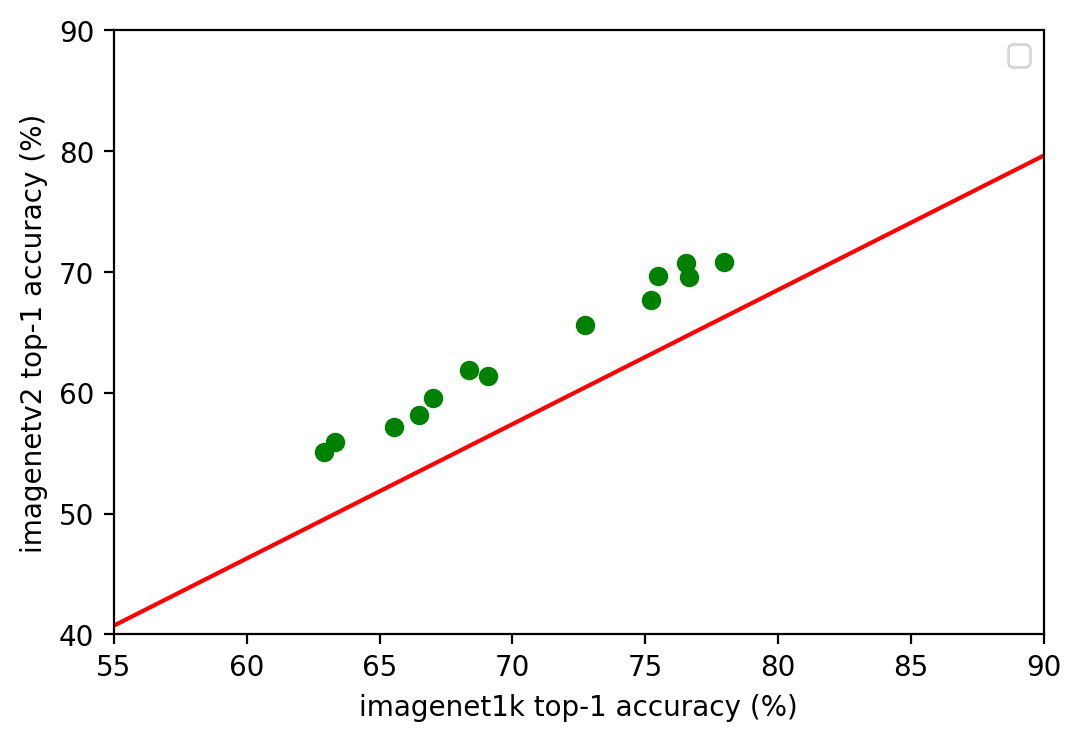

In [24]:
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values="acc1").T.dropna()
dataset = "imagenetv2"
line_fits_data = {
    # slopes and intercepts from https://share.streamlit.io/modestyachts/imagenet-testbed-website/main/website.py
    "imagenetv2": (1.112, -20.433),
    "imagenet-r": (1.549, -104.556),
    "imagenet_sketch": (0.931, -45.373)
}
x=np.linspace(0, 100,100)
slope, intercept = line_fits_data[dataset]
y=x*slope+intercept
plt.xlim(55,90)
plt.ylim(40,90)
d = df_metric.T[["imagenet1k", dataset]]*100
plt.scatter(d["imagenet1k"], d[dataset], color="green")
plt.plot(x,y, color="red")
plt.xlabel("imagenet1k top-1 accuracy (%)")
plt.ylabel(f"{dataset} top-1 accuracy (%)")
plt.legend()

### All results (mean_per_class_recall)

In [25]:
metric = "mean_per_class_recall"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 laion2b_s34b_b79k,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-H-14 laion2b_s32b_b79k,ViT-L-14 laion2b_s32b_b82k,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai,ViT-g-14 laion2b_s12b_b42k
dataset,,,,,,,,,,,,,
cars,0.838,0.647,0.846,0.844,0.862,0.597,0.793,0.935,0.926,0.896,0.777,0.793,0.929
country211,0.182,0.228,0.188,0.164,0.167,0.171,0.147,0.299,0.263,0.231,0.318,0.345,0.288
fer2013,0.392,0.417,0.394,0.465,0.433,0.359,0.399,0.506,0.534,0.450,0.489,0.491,0.481
fgvc_aircraft,0.175,0.241,0.188,0.232,0.246,0.197,0.166,0.426,0.365,0.248,0.317,0.332,0.378
gtsrb,0.401,0.370,0.432,0.351,0.435,0.320,0.393,0.544,0.517,0.450,0.439,0.447,0.466
imagenet-a,0.341,0.483,0.381,0.284,0.279,0.324,0.235,0.581,0.536,0.473,0.675,0.735,0.564
imagenet-r,0.764,0.761,0.791,0.744,0.752,0.679,0.721,0.880,0.860,0.833,0.865,0.878,0.875
imagenet1k,0.670,0.684,0.692,0.656,0.665,0.633,0.629,0.780,0.753,0.727,0.754,0.766,0.767
imagenet_sketch,0.523,0.482,0.545,0.529,0.537,0.423,0.494,0.666,0.633,0.596,0.596,0.610,0.652


### All results (mAP)

In [26]:
# For multi-label classification tasks
metric = "mean_average_precision"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 laion2b_s34b_b79k,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-H-14 laion2b_s32b_b79k,ViT-L-14 laion2b_s32b_b82k,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai,ViT-g-14 laion2b_s12b_b42k
dataset,,,,,,,,,,,,,
voc2007_multilabel,0.784,0.789,0.785,0.793,0.796,0.760,0.762,0.801,0.820,0.785,0.790,0.804,0.807


## All results (retrieval)

In [27]:
metric = "image_retrieval_recall@5"
pd.pivot(df_retrieval, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 laion2b_s34b_b79k,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-H-14 laion2b_s32b_b79k,ViT-L-14 laion2b_s32b_b82k,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai,ViT-g-14 laion2b_s12b_b42k
dataset,,,,,,,,,,,,,
flickr30k,0.882,0.855,0.889,0.881,0.884,0.834,0.855,0.941,0.929,0.908,0.872,0.889,0.935
flickr8k,0.620,0.564,0.644,0.622,0.629,0.532,0.579,0.745,0.712,0.675,0.598,0.627,0.730
mscoco_captions,0.636,0.584,0.662,0.647,0.654,0.558,0.608,0.734,0.711,0.681,0.611,0.616,0.724


In [28]:
metric = "text_retrieval_recall@5"
pd.pivot(df_retrieval, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 laion2b_s34b_b79k,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-H-14 laion2b_s32b_b79k,ViT-L-14 laion2b_s32b_b82k,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai,ViT-g-14 laion2b_s12b_b42k
dataset,,,,,,,,,,,,,
flickr30k,0.968,0.963,0.971,0.964,0.963,0.949,0.941,0.993,0.987,0.978,0.974,0.981,0.991
flickr8k,0.767,0.728,0.792,0.761,0.778,0.699,0.739,0.856,0.822,0.806,0.766,0.780,0.846
mscoco_captions,0.796,0.768,0.810,0.795,0.798,0.748,0.768,0.860,0.840,0.822,0.792,0.810,0.854


## Aggregating over datasets

See VTAB (https://arxiv.org/pdf/1910.04867.pdf, Section E) for a discussion about different aggregation 
strategies and how much they correlate. They find that all aggregation strategies have high
Kendall score with the simple top-1 mean accuracy over datasets.

### Ranking the models over mean top-1 accuracy over all datasets

In [29]:
df.groupby("model_fullname").agg(['mean', 'std', 'median']).sort_values(by=("acc1", "mean"), ascending=False)

acc1               acc5               \
                                  mean   std median  mean   std median   
model_fullname                                                           
ViT-L-14-336 openai              0.567 0.287  0.637 0.826 0.239  0.926   
ViT-g-14 laion2b_s12b_b42k       0.565 0.290  0.648 0.833 0.238  0.935   
ViT-H-14 laion2b_s32b_b79k       0.564 0.301  0.666 0.836 0.239  0.925   
ViT-L-14 openai                  0.558 0.286  0.635 0.823 0.239  0.917   
ViT-L-14 laion2b_s32b_b82k       0.546 0.288  0.593 0.820 0.239  0.904   
ViT-L-14 laion400m_e32           0.518 0.296  0.596 0.802 0.243  0.901   
ViT-B-32 laion2b_s34b_b79k       0.508 0.281  0.557 0.783 0.246  0.886   
ViT-B-16-plus-240 laion400m_e32  0.493 0.282  0.544 0.780 0.248  0.862   
ViT-B-16 laion400m_e32           0.484 0.280  0.515 0.779 0.246  0.882   
ViT-B-32 laion2b_e16             0.481 0.280  0.504 0.778 0.249  0.858   
ViT-B-16 openai                  0.475 0.273  0.501 0.783 0.233  0.854   
ViT-B-32-quickgelu laion400m_e32 0.458 0.272  0.493 0.757 0.254  0.858   
ViT-B-32 openai                  0.449 0.262  0.443 0.764 0.239  0.854   

                                 mean_per_class_recall               \
                                                  mean   std median   
model_fullname                                                        
ViT-L-14-336 openai                              0.558 0.292  0.631   
ViT-g-14 laion2b_s12b_b42k                       0.563 0.297  0.646   
ViT-H-14 laion2b_s32b_b79k                       0.572 0.298  0.666   
ViT-L-14 openai                                  0.550 0.291  0.638   
ViT-L-14 laion2b_s32b_b82k                       0.551 0.290  0.593   
ViT-L-14 laion400m_e32                           0.522 0.296  0.586   
ViT-B-32 laion2b_s34b_b79k                       0.494 0.285  0.537   
ViT-B-16-plus-240 laion400m_e32                  0.500 0.280  0.545   
ViT-B-16 laion400m_e32                           0.488 0.278  0.511   
ViT-B-32 laion2b_e16                             0.484 0.280  0.511   
ViT-B-16 openai                                  0.483 0.269  0.506   
ViT-B-32-quickgelu laion400m_e32                 0.459 0.276  0.494   
ViT-B-32 openai                                  0.450 0.267  0.443   

                                 mean_average_precision             
                                                   mean std median  
model_fullname                                                      
ViT-L-14-336 openai                               0.804 NaN  0.804  
ViT-g-14 laion2b_s12b_b42k                        0.807 NaN  0.807  
ViT-H-14 laion2b_s32b_b79k                        0.801 NaN  0.801  
ViT-L-14 openai                                   0.790 NaN  0.790  
ViT-L-14 laion2b_s32b_b82k                        0.820 NaN  0.820  
ViT-L-14 laion400m_e32                            0.785 NaN  0.785  
ViT-B-32 laion2b_s34b_b79k                        0.796 NaN  0.796  
ViT-B-16-plus-240 laion400m_e32                   0.785 NaN  0.785  
ViT-B-16 laion400m_e32                            0.784 NaN  0.784  
ViT-B-32 laion2b_e16                              0.793 NaN  0.793  
ViT-B-16 openai                                   0.789 NaN  0.789  
ViT-B-32-quickgelu laion400m_e32                  0.762 NaN  0.762  
ViT-B-32 openai                                   0.760 NaN  0.760

### Compute rank of the model for each dataset (1 = best, lower is better), then average the ranks over the datasets

In [32]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric.rank(axis=1,ascending=False).agg(["mean", "std"]).T.sort_values(by="mean",ascending=True)

,mean,std
model_fullname,,
ViT-g-14 laion2b_s12b_b42k,3.286,2.295
ViT-H-14 laion2b_s32b_b79k,3.786,3.355
ViT-L-14 laion2b_s32b_b82k,4.529,2.440
ViT-L-14-336 openai,4.871,3.037
ViT-L-14 openai,5.343,3.038
ViT-L-14 laion400m_e32,6.829,2.925
ViT-B-32 laion2b_s34b_b79k,7.114,3.332
ViT-B-16-plus-240 laion400m_e32,7.971,2.285
ViT-B-16 laion400m_e32,8.543,2.822
